In [1]:
# Cell 1: Imports and Global Settings
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler # MinMaxScaler added for radar chart
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy.stats import norm
import warnings
import squarify
import plotly.express as px  
import plotly.graph_objects as go

warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100) 

In [2]:
# Cell 2: Radar Chart Plotting Function Definition
def create_radar_chart(data, title, features):
    """
    Creates a radar chart to visualize cluster profiles.

    Args:
        data (pd.DataFrame): DataFrame with clusters as index and scaled features as columns.
        title (str): The main title for the radar chart.
        features (list): A list of strings, where each string is the name of a feature
                         to be plotted on an axis of the radar chart.
                         These names should match the column names in 'data'.
    """
    num_features = len(features)
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1] # Complete the loop for plotting

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for i, row in data.iterrows():
        values = row[features].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1.5, linestyle='solid', label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.05)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, color='grey', size=12)

    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], color='grey', size=8)
    ax.tick_params(axis='y', labelsize=8)

    plt.title(title, size=18, color='black', y=1.08)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.show()

In [3]:
# Cell 3: Data Loading and Combination
print("--- Data Loading and Combination ---")
try:
    df_2009_2010 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2009-2010')
except FileNotFoundError:
    print("Error: 'online_retail_II.xlsx' for 2009-2010 not found. Attempting CSV fallback for 2009-2010.")
    try:
        df_2009_2010 = pd.read_csv('online_retail_II.csv', encoding='ISO-8859-1')
    except FileNotFoundError:
        print("Error: 'online_retail_II.csv' also not found for 2009-2010.")
        df_2009_2010 = pd.DataFrame() 

try:
    df_2010_2011 = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
except FileNotFoundError:
    print("Error: 'online_retail_II.xlsx' for 2010-2011 not found.")
    df_2010_2011 = pd.DataFrame() # Create empty DataFrame

df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)
print(f"Combined DataFrame shape after loading: {df.shape}")
print("First 5 rows of the combined DataFrame:")
print(df.head()) # Added to show initial loaded data

--- Data Loading and Combination ---
Combined DataFrame shape after loading: (1067371, 8)
First 5 rows of the combined DataFrame:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [4]:
# Cell 4: Data Cleaning
print("\n--- Data Cleaning ---")
df_cleaned = df.copy()
df_cleaned.dropna(subset=['Customer ID'], inplace=True) # Drop rows where Customer ID is missing
df_cleaned = df_cleaned[~df_cleaned['Invoice'].astype(str).str.contains('C', na=False)] # Remove cancelled orders
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0] # Remove items with zero or negative quantity
df_cleaned = df_cleaned[df_cleaned['Price'] > 0] # Remove items with zero or negative price

df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate']) # Convert InvoiceDate to datetime
df_cleaned['Customer ID'] = df_cleaned['Customer ID'].astype(int) # Convert Customer ID to integer
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['Price'] # Calculate TotalPrice for each transaction

print("Data cleaning complete. Cleaned DataFrame info:")
df_cleaned.info()
print("\nFirst 5 rows of the cleaned DataFrame:")
print(df_cleaned.head())


--- Data Cleaning ---
Data cleaning complete. Cleaned DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  int64         
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 61.5+ MB

First 5 rows of the cleaned DataFrame:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434  

In [5]:
# Cell 5: RFM Feature Calculation
print("\n--- RFM Feature Calculation ---")
# Find the last transaction date and set a snapshot date 1 day after
snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)

# Calculate RFM values for each unique customer
rfm = df_cleaned.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days), # Days since last purchase
    Frequency=('Invoice', 'nunique'), # Number of unique invoices (purchases)
    Monetary=('TotalPrice', 'sum') # Total amount spent
)

print("RFM calculation complete. Sample RFM data:")
print(rfm.head())
print(f"Number of unique customers (RFM rows): {rfm.shape[0]}")


--- RFM Feature Calculation ---
RFM calculation complete. Sample RFM data:
             Recency  Frequency  Monetary
Customer ID                              
12346            326         12  77556.46
12347              2          8   5633.32
12348             75          5   2019.40
12349             19          4   4428.69
12350            310          1    334.40
Number of unique customers (RFM rows): 5878


In [6]:
# Cell 6: Feature Scaling
print("\n--- Feature Scaling ---")
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Scale the RFM features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index) # Convert back to DataFrame

print("RFM features scaled. Sample scaled data:")
print(X_scaled_df.head())


--- Feature Scaling ---
RFM features scaled. Sample scaled data:
              Recency  Frequency  Monetary
Customer ID                               
12346        0.595584   0.438998  5.058050
12347       -0.952279   0.131502  0.177431
12348       -0.603532  -0.099120 -0.067806
12349       -0.871064  -0.175994  0.095686
12350        0.519146  -0.406616 -0.182148



--- Initial RFM Distribution Plots ---


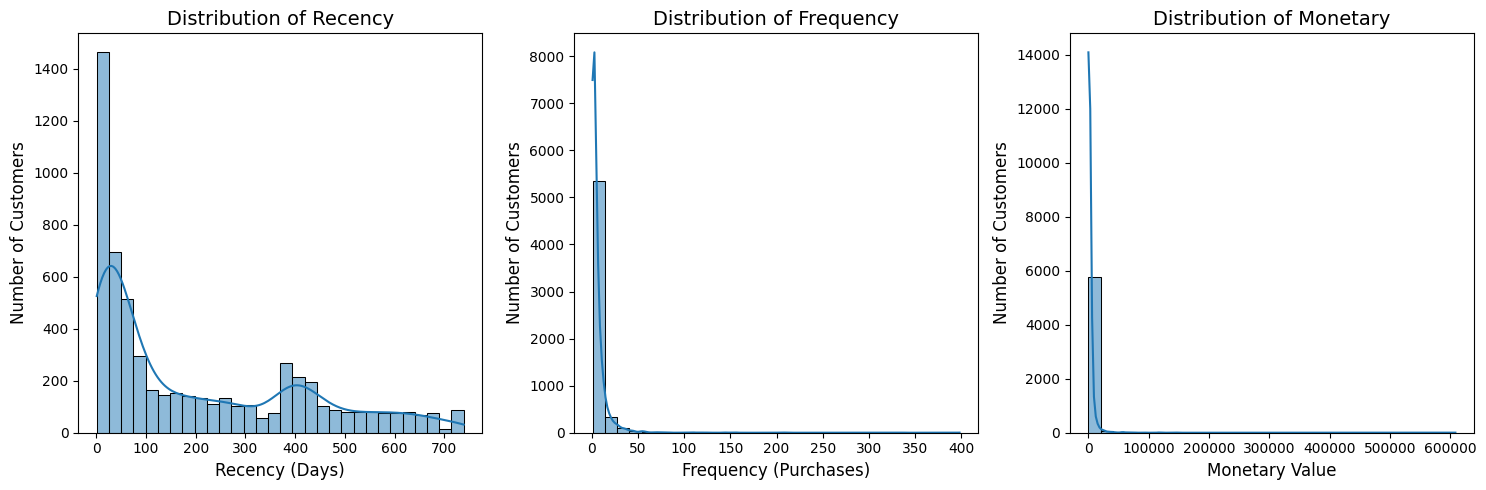

In [7]:
# Cell 7: Initial RFM Distribution Plots
print("\n--- Initial RFM Distribution Plots ---")
plt.figure(figsize=(15, 5)) # Increased figure size for better readability

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True, bins=30)
plt.title('Distribution of Recency', fontsize=14)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True, bins=30)
plt.title('Distribution of Frequency', fontsize=14)
plt.xlabel('Frequency (Purchases)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], kde=True, bins=30)
plt.title('Distribution of Monetary', fontsize=14)
plt.xlabel('Monetary Value', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.tight_layout()
plt.show()


--- Correlation Matrix of Scaled RFM Features ---


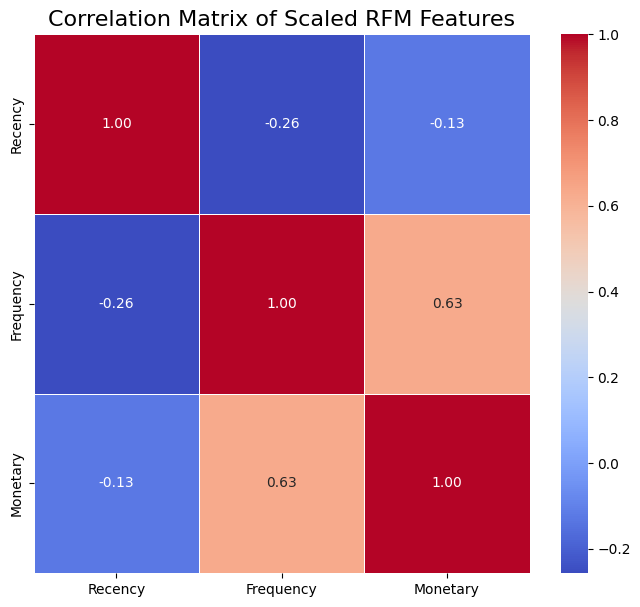

In [8]:
# Cell 8: Correlation Matrix of Scaled RFM Features
print("\n--- Correlation Matrix of Scaled RFM Features ---")
plt.figure(figsize=(8, 7)) # Adjusted size slightly
sns.heatmap(X_scaled_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Scaled RFM Features', fontsize=16)
plt.show()


--- GMM Model Selection (BIC and AIC Scores) ---


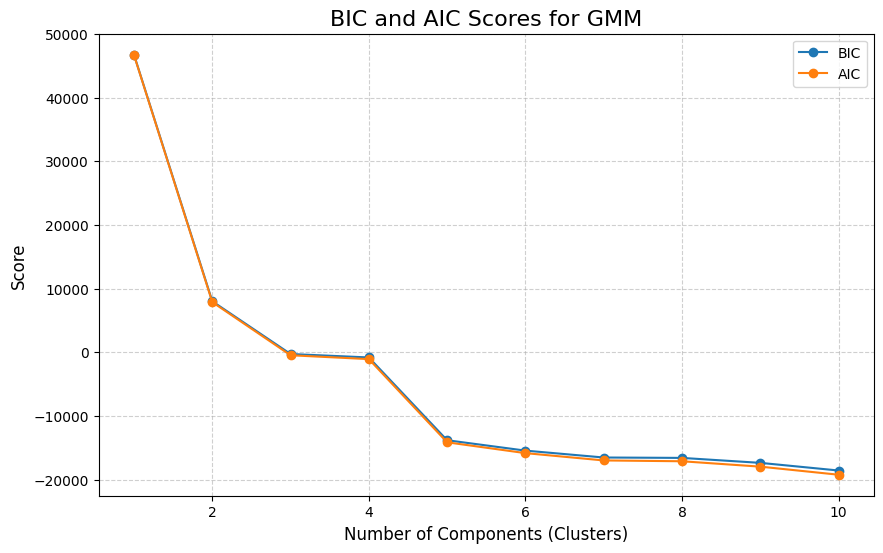

Optimal number of components (minimizing BIC): 10


In [9]:
# Cell 9: GMM Model Selection (BIC/AIC)
print("\n--- GMM Model Selection (BIC and AIC Scores) ---")
n_components = np.arange(1, 11) # Test 1 to 10 clusters
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

plt.figure(figsize=(10, 6)) 
plt.plot(n_components, [m.bic(X_scaled) for m in models], label='BIC', marker='o')
plt.plot(n_components, [m.aic(X_scaled) for m in models], label='AIC', marker='o')
plt.xlabel('Number of Components (Clusters)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('BIC and AIC Scores for GMM', fontsize=16)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


best_n_bic = n_components[np.argmin([m.bic(X_scaled) for m in models])]
print(f"Optimal number of components (minimizing BIC): {best_n_bic}")


n_clusters = best_n_bic

In [10]:
# Cell 10: GMM Clustering & Assignment
print("\n--- GMM Clustering & Assignment ---")
# Use the optimal number of clusters determined in the previous step
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X_scaled)

# Get cluster assignments (hard assignment: each customer belongs to one cluster)
cluster_labels = gmm.predict(X_scaled)
rfm['Cluster'] = cluster_labels # Add the cluster labels back to the rfm DataFrame

print(f"Assigned {n_clusters} clusters to the RFM data.")
print("Sample RFM data with cluster assignments:")
print(rfm.head())
print(f"\nCluster distribution:\n{rfm['Cluster'].value_counts().sort_index()}")


--- GMM Clustering & Assignment ---
Assigned 10 clusters to the RFM data.
Sample RFM data with cluster assignments:
             Recency  Frequency  Monetary  Cluster
Customer ID                                       
12346            326         12  77556.46        3
12347              2          8   5633.32        1
12348             75          5   2019.40        0
12349             19          4   4428.69        1
12350            310          1    334.40        9

Cluster distribution:
Cluster
0     914
1     892
2       2
3     105
4      42
5     792
6      60
7     459
8    1068
9    1544
Name: count, dtype: int64


In [11]:
# Cell 11: Cluster Profiling
print("\n--- Cluster Profiles (Mean & Median RFM Values per Cluster) ---")
cluster_summary = rfm.groupby('Cluster').agg(
    Recency_Mean=('Recency', 'mean'),
    Recency_Median=('Recency', 'median'),
    Frequency_Mean=('Frequency', 'mean'),
    Frequency_Median=('Frequency', 'median'),
    Monetary_Mean=('Monetary', 'mean'),
    Monetary_Median=('Monetary', 'median'),
    # CORRECTED LINE BELOW:
    # We can count any of the RFM columns, or simply use .size()
    Customer_Count=('Recency', 'count') # Counts the number of Recency entries (i.e., customers) in each cluster
).round(2)

# Add percentage of customers in each cluster
cluster_summary['Customer_Percentage'] = (cluster_summary['Customer_Count'] / cluster_summary['Customer_Count'].sum() * 100).round(2)

print("\nComprehensive Cluster Profiles:")
print(cluster_summary)


--- Cluster Profiles (Mean & Median RFM Values per Cluster) ---

Comprehensive Cluster Profiles:
         Recency_Mean  Recency_Median  Frequency_Mean  Frequency_Median  \
Cluster                                                                   
0              274.44           241.5            4.83               4.0   
1               23.40            19.0            9.63               9.0   
2                1.50             1.5          148.00             148.0   
3              288.86           281.0           15.55              12.0   
4               12.38            10.0           52.69              46.5   
5              340.12           369.5            2.29               2.0   
6                2.55             2.0           73.65              52.0   
7               44.25            26.0           18.24              17.0   
8               34.40            29.0            3.43               3.0   
9              359.00           390.0            1.00               1.0   

 


--- Visualizing Clusters (Scatter, Pair, Violin/Box Plots) ---


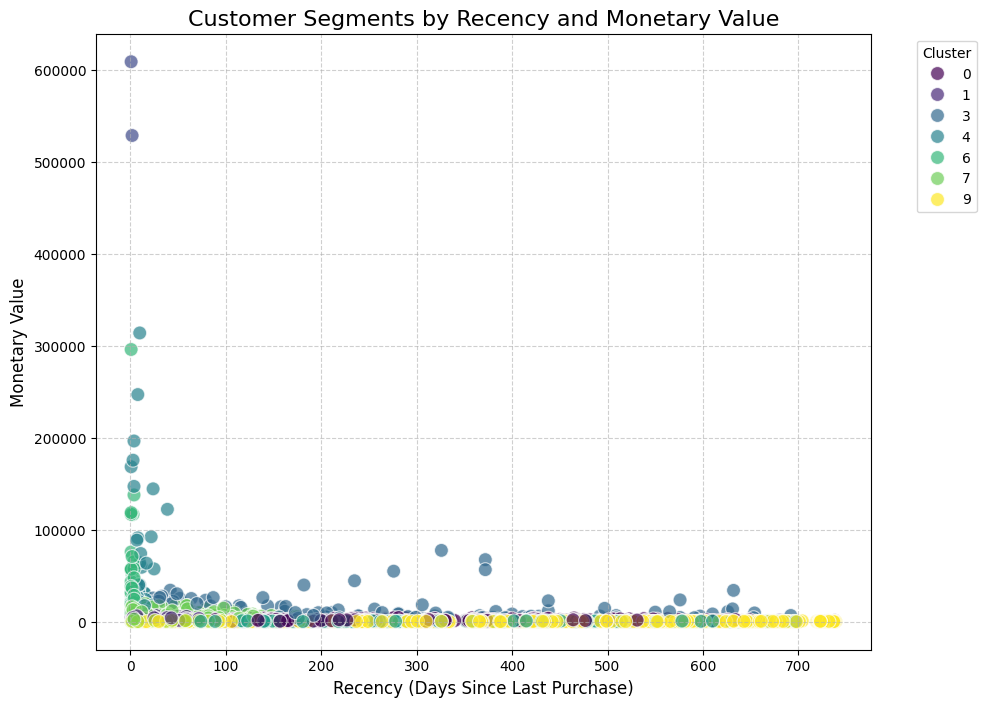


Generating Pair Plot (this might take a moment)...


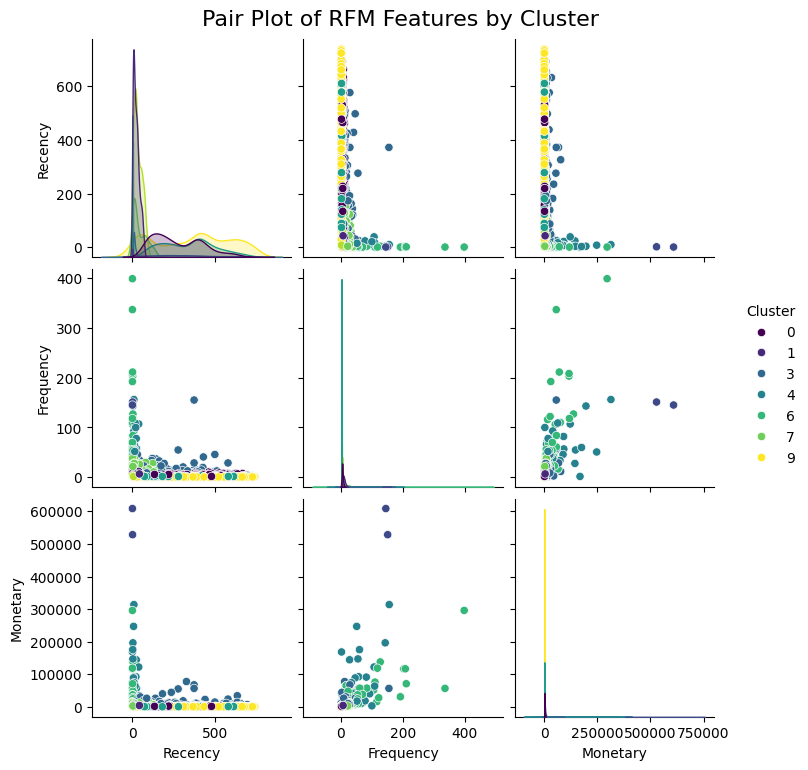

Pair Plot generated.


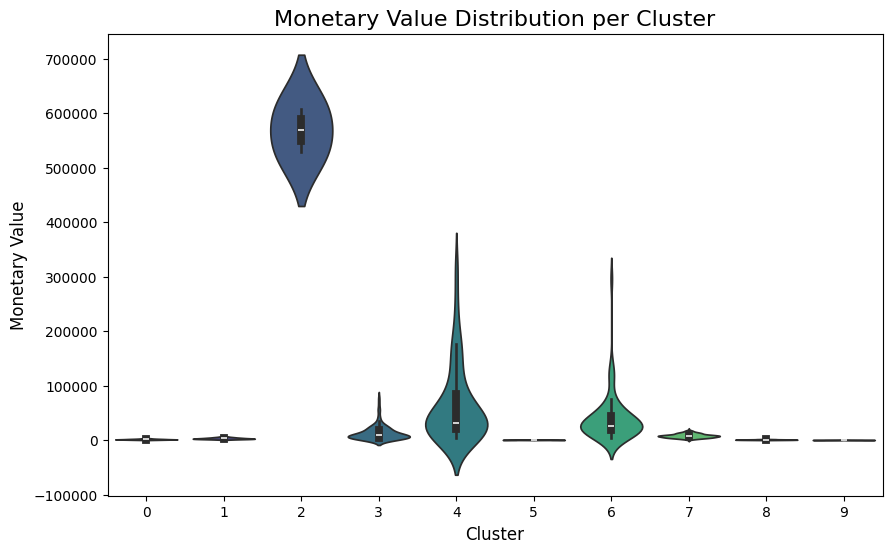

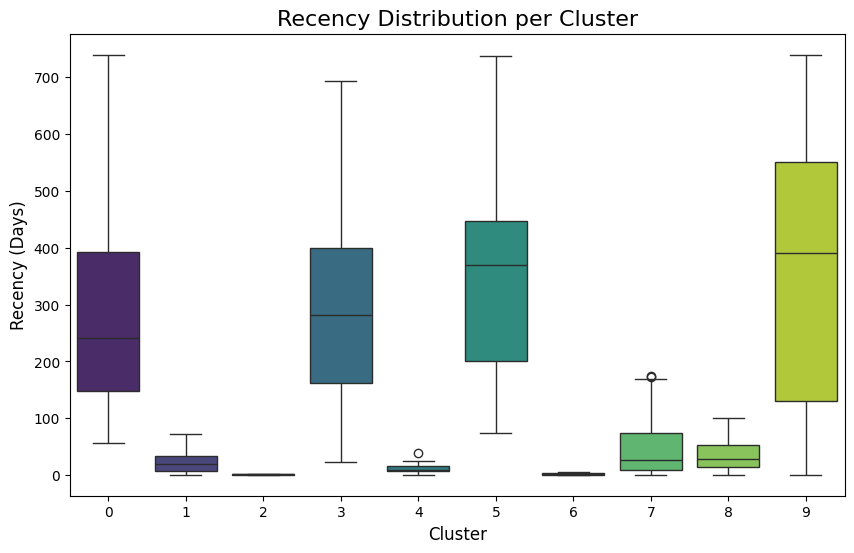

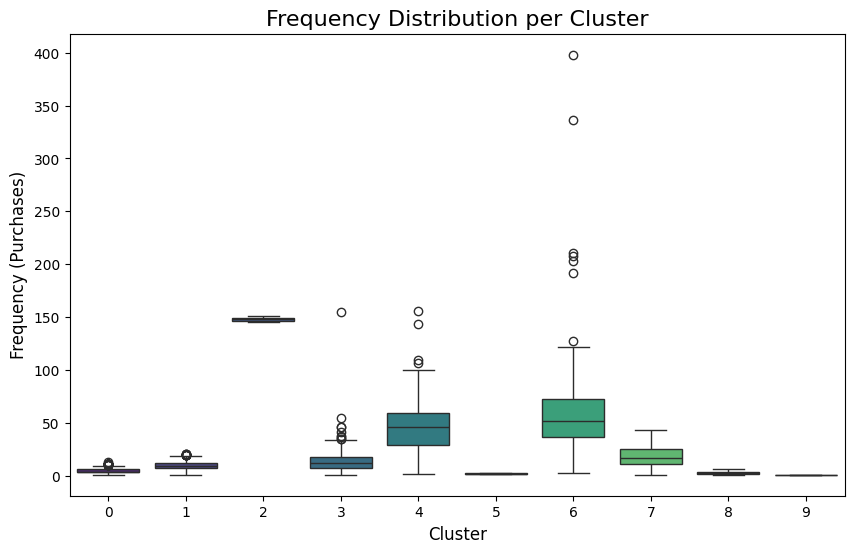

In [12]:
# Cell 12: Cluster Visualizations (Scatter, Pair, Violin/Box Plots)
print("\n--- Visualizing Clusters (Scatter, Pair, Violin/Box Plots) ---")

# Scatter plot of Recency vs Monetary with Cluster hue
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments by Recency and Monetary Value', fontsize=16)
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Monetary Value', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left') # Moved legend for less overlap
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Pair plot with cluster hue (more comprehensive, but can take time for large datasets)
print("\nGenerating Pair Plot (this might take a moment)...")
sns.pairplot(rfm, vars=['Recency', 'Frequency', 'Monetary'], hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot of RFM Features by Cluster', y=1.02, fontsize=16) # y=1.02 to prevent title overlap
plt.show()
print("Pair Plot generated.")

# Distribution of Monetary Value per Cluster (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')
plt.title('Monetary Value Distribution per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Monetary Value', fontsize=12)
plt.show()

# Distribution of Recency per Cluster (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
plt.title('Recency Distribution per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Recency (Days)', fontsize=12)
plt.show()

# Distribution of Frequency per Cluster (Box Plot - or violin if preferred)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
plt.title('Frequency Distribution per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Frequency (Purchases)', fontsize=12)
plt.show()

In [13]:
# Cell 12(new): Automatic Cluster Interpretation and Naming

print("\n--- Automatic Cluster Interpretation and Naming ---")

# --- IMPORTANT: Data Preparation for Naming Logic ---
print("Preparing scaled RFM means for automatic naming...")
cluster_means_scaled_for_radar = pd.DataFrame(columns=['Recency', 'Frequency', 'Monetary'])

try:
    cluster_means_for_naming = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

    if not cluster_means_for_naming.empty:
        scaler_radar_for_naming = MinMaxScaler()
        cluster_means_scaled_for_radar = pd.DataFrame(
            scaler_radar_for_naming.fit_transform(cluster_means_for_naming),
            columns=cluster_means_for_naming.columns,
            index=cluster_means_for_naming.index
        )
        cluster_means_scaled_for_radar['Recency'] = 1 - cluster_means_scaled_for_radar['Recency']

        print("\nSUCCESS: 'cluster_means_scaled_for_radar' has been created.")
        print("Content of 'cluster_means_scaled_for_radar':")
        print(cluster_means_scaled_for_radar)
    else:
        print("\nWARNING: 'cluster_means_for_naming' is empty after groupby. No scaled means generated.")

except KeyError as ke:
    print(f"\nERROR: KeyError during data preparation for naming: {ke}")
    print("This often means 'Recency', 'Frequency', or 'Monetary' columns are missing or incorrectly named after RFM calculation.")
    print("Please check Cell 5 (RFM Feature Calculation) and ensure column names are correct.")
    raise # Re-raise to stop execution and highlight the upstream issue
except Exception as e:
    print(f"\nAN UNEXPECTED ERROR OCCURRED during data preparation for naming: {e}")
    raise # Re-raise any other unexpected exceptions

print("-" * 50)


# --- Define Dynamic Thresholds based on Cluster Means (ADJUSTED FOR CORRECT SCALED VALUES) ---
dynamic_thresholds = {}
if not cluster_means_scaled_for_radar.empty:
    for col in ['Recency', 'Frequency', 'Monetary']:
        # These percentiles are adjusted to create better separation based on the *correct* scaled values.
        if col == 'Recency': # Recency is inverted, so lower percentile for 'good' means higher value
            dynamic_thresholds[col + '_EXTREME_RECENT_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.97) # Catches C2, C6
            dynamic_thresholds[col + '_VERY_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.4)  # Catches C1, C4, C7, C8
            dynamic_thresholds[col + '_MODERATELY_RECENT_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.12) # Catches C0, C3
            dynamic_thresholds[col + '_INACTIVE_BORDER_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.04) # Catches C5 (distinguishes from C9)
            # Below this is 'Extremely Inactive' for C9 (effectively 0)
        
        elif col == 'Frequency': # Frequency is not inverted
            dynamic_thresholds[col + '_EXTREME_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.99) # Catches C2
            dynamic_thresholds[col + '_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.75)        # Catches C4, C6
            dynamic_thresholds[col + '_MEDIUM_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.50) # Catches C3, C7
            dynamic_thresholds[col + '_MEDIUM_LOW_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.3)  # Catches C0, C1
            dynamic_thresholds[col + '_VERY_LOW_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.005)   # Catches C5, C8
            # Below this is 'Extremely Low' for C9 (effectively 0)

        elif col == 'Monetary': # Monetary is not inverted (This was your 'else' block)
            dynamic_thresholds[col + '_EXTREME_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.99)  # Catches C2
            dynamic_thresholds[col + '_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.85)        # Catches C4, C6
            dynamic_thresholds[col + '_MEDIUM_HIGH_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.6)  # Catches C3, C7
            dynamic_thresholds[col + '_MEDIUM_LOW_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.55) # Catches C0, C1
            dynamic_thresholds[col + '_VERY_LOW_MIN'] = cluster_means_scaled_for_radar[col].quantile(0.0009)  # Catches C5, C8
            # Below this is 'Extremely Low' for C9 (effectively 0)

    print("\nDynamically Calculated Thresholds (Adjusted):")
    for key, value in dynamic_thresholds.items():
        print(f"  {key}: {value:.8f}")
    print("-" * 50)


# --- Definition of interpret_rfm_cluster function (WITH MORE QUALITATIVE LEVELS) ---
def interpret_rfm_cluster(recency_scaled, frequency_scaled, monetary_scaled, thresholds):
    """
    Interprets a cluster based on its scaled RFM values and assigns a name,
    using dynamically provided thresholds.
    Recency_scaled is assumed to be inverted (higher value = more recent, range 0-1).
    """
    # Retrieve dynamic thresholds
    R_EXTREME_RECENT_MIN = thresholds['Recency_EXTREME_RECENT_MIN']
    R_VERY_HIGH_MIN = thresholds['Recency_VERY_HIGH_MIN']
    R_MODERATELY_RECENT_MIN = thresholds['Recency_MODERATELY_RECENT_MIN']
    R_INACTIVE_BORDER_MIN = thresholds['Recency_INACTIVE_BORDER_MIN']

    F_EXTREME_HIGH_MIN = thresholds['Frequency_EXTREME_HIGH_MIN']
    F_HIGH_MIN = thresholds['Frequency_HIGH_MIN']
    F_MEDIUM_HIGH_MIN = thresholds['Frequency_MEDIUM_HIGH_MIN']
    F_MEDIUM_LOW_MIN = thresholds['Frequency_MEDIUM_LOW_MIN']
    F_VERY_LOW_MIN = thresholds['Frequency_VERY_LOW_MIN']

    M_EXTREME_HIGH_MIN = thresholds['Monetary_EXTREME_HIGH_MIN']
    M_HIGH_MIN = thresholds['Monetary_HIGH_MIN']
    M_MEDIUM_HIGH_MIN = thresholds['Monetary_MEDIUM_HIGH_MIN']
    M_MEDIUM_LOW_MIN = thresholds['Monetary_MEDIUM_LOW_MIN']
    M_VERY_LOW_MIN = thresholds['Monetary_VERY_LOW_MIN']


    # Assign qualitative labels based on these dynamic thresholds (more granular levels)
    r_level = ""
    if recency_scaled >= R_EXTREME_RECENT_MIN : r_level = "Extreme Recent"
    elif recency_scaled >= R_VERY_HIGH_MIN and recency_scaled < 0.998: r_level = "Very High Recent"
    elif recency_scaled >= R_MODERATELY_RECENT_MIN and recency_scaled < 0.4: r_level = "Moderately Recent"
    elif recency_scaled >= R_INACTIVE_BORDER_MIN: r_level = "Inactive Border"
    else: r_level = "Extremely Inactive"

    f_level = ""
    if frequency_scaled >= F_EXTREME_HIGH_MIN: f_level = "Extreme High F"
    elif frequency_scaled >= F_HIGH_MIN  : f_level = "High F"
    elif frequency_scaled >= F_MEDIUM_HIGH_MIN and frequency_scaled<=0.2: f_level = "Medium High F"
    elif frequency_scaled >= F_MEDIUM_LOW_MIN and frequency_scaled: f_level = "Medium Low F"
    elif frequency_scaled >= F_VERY_LOW_MIN and frequency_scaled: f_level = "Very Low F"
    else: f_level = "Extremely Low F"

    m_level = ""
    if monetary_scaled >= M_EXTREME_HIGH_MIN: m_level = "Extreme High M"
    elif monetary_scaled >= M_HIGH_MIN: m_level = "High M"
    elif monetary_scaled >= M_MEDIUM_HIGH_MIN: m_level = "Medium High M"
    elif monetary_scaled >= M_MEDIUM_LOW_MIN: m_level = "Medium Low M"
    elif monetary_scaled >= M_VERY_LOW_MIN: m_level = "Very Low M"
    else: m_level = "Extremely Low M"


    # --- Rule-Based Naming Logic (ORDER IS CRUCIAL) ---
    # Craft rules to capture your manual interpretations using these more granular levels.

    # 1. Lost Customer (Absolute zero) - Most extreme, check first. Absolute check, not percentile.
    if (recency_scaled < 1e-15 and frequency_scaled < 1e-15 and monetary_scaled < 1e-15):
        return "Lost Customer (Absolute zero)"

    # 2. Champions - Max values
    if r_level == "Extreme Recent" and f_level == "Extreme High F" and m_level == "Extreme High M":
        return "Champions"

    # 3. Elite loyal customers
    if r_level == "Very High Recent" and f_level == "High F" and m_level == "Medium High M": # C6: R=0.997, F=0.494, M=0.070
        return "Elite loyal customers"

    # 4. High value loyalists
    if r_level == "Very High Recent" and f_level == "High F" and m_level == "High M": # C4: R=0.969, F=0.35, M=0.11
        return "High value loyalists"
    
    # 5. Promising loyalists/Active mid tier
    if r_level == "Very High Recent" and f_level == "Medium High F" and m_level == "Medium Low M": # C7: R=0.088, F=0.11, M=0.014
        return "Promising loyalists/Active mid tier"

    # 6. New Customers (Potential)
    if r_level == "Very High Recent" and f_level == "Medium Low F" and m_level == "Very Low M": # C1: R=0.093, F=0.058, M=0.005
        return "New Customers (Potential)"

    # 7. New customers (Low engagement)
    if r_level == "Very High Recent" and f_level == "Very Low F" and m_level == "Very Low M": # C8: R=0.090, F=0.016, M=0.001
        return "New customers (Low engagement)"

    # 8. At risk
    if r_level == "Moderately Recent" and f_level == "Medium High F" and m_level == "Medium High M": # C3: R=0.196, F=0.098, M=0.023
        return "At risk"

    # 9. Dormant (inactive)
    if r_level == "Moderately Recent" and f_level == "Medium Low F" and m_level == "Very Low M": # C0: R=0.236, F=0.026, M=0.002
        return "Dormant (inactive)"
        
    # 10. Nearly Lost - Extremely inactive, but not absolute zero.
    if r_level == "Inactive Border" and f_level == "Very Low F" and m_level == "Very Low M": # C5: R=0.00000005, F=0.008, M=0.0004
         # Ensure it's not the absolute zero case
        if not (recency_scaled < 1e-15 and frequency_scaled < 1e-15 and monetary_scaled < 1e-15):
            return "Nearly Lost"

    # Fallback for any un-categorized combinations
    return "Other Segment - Undefined"


# --- Application of Interpretation Function (UPDATED TO PASS DYNAMIC THRESHOLDS) ---
auto_cluster_names = {}
name_counts = {}

if not cluster_means_scaled_for_radar.empty:
    for cluster_id, row in cluster_means_scaled_for_radar.iterrows():
        # Pass the dynamically calculated thresholds to the function
        base_name = interpret_rfm_cluster(row['Recency'], row['Frequency'], row['Monetary'], dynamic_thresholds)
        
        # Add disambiguation for duplicate names
        if base_name in name_counts:
            name_counts[base_name] += 1
            auto_cluster_names[cluster_id] = f"{base_name} ({name_counts[base_name]})"
        else:
            name_counts[base_name] = 1
            auto_cluster_names[cluster_id] = base_name

    print("\nAutomatically Interpreted Cluster Names:")
    auto_names_df = pd.DataFrame(list(auto_cluster_names.items()), columns=['Cluster ID', 'Auto-Assigned Name'])
    print(auto_names_df)

    if 'cluster_summary' in locals() and not cluster_summary.empty:
        cluster_summary['Auto_Cluster_Name'] = cluster_summary.index.map(auto_cluster_names)
        print("\nCluster Summary with Auto-Assigned Names (first 10 rows):")
        print(cluster_summary.head(10))
    else:
        print("Warning: 'cluster_summary' DataFrame is empty or not found. Cannot add auto-assigned names to it.")
else:
    print("\nWarning: 'cluster_means_scaled_for_radar' is empty. Skipping cluster naming application.")



--- Automatic Cluster Interpretation and Naming ---
Preparing scaled RFM means for automatic naming...

SUCCESS: 'cluster_means_scaled_for_radar' has been created.
Content of 'cluster_means_scaled_for_radar':
              Recency  Frequency  Monetary
Cluster                                   
0        2.365364e-01   0.026087  0.002406
1        9.387502e-01   0.058693  0.005333
2        1.000000e+00   1.000000  1.000000
3        1.962053e-01   0.098996  0.023748
4        9.695638e-01   0.351636  0.112737
5        5.282011e-02   0.008804  0.000468
6        9.970629e-01   0.494218  0.070270
7        8.804244e-01   0.117306  0.014040
8        9.079806e-01   0.016548  0.001153
9        1.110223e-16   0.000000  0.000000
--------------------------------------------------

Dynamically Calculated Thresholds (Adjusted):
  Recency_EXTREME_RECENT_MIN: 0.99920699
  Recency_VERY_HIGH_MIN: 0.62286918
  Recency_MODERATELY_RECENT_MIN: 0.06429092
  Recency_INACTIVE_BORDER_MIN: 0.01901524
  Frequency_E

In [14]:
# Cell 13: Interactive Treemap Visualization (using Plotly)

print("\n--- Generating Interactive Treemap of Customer Segments (Plotly) ---")

# Ensure cluster_summary (from Cell 11) and auto_cluster_names (from Cell 12) are available.

# Prepare data for Plotly Treemap
treemap_df_data = []
total_customers_for_treemap = cluster_summary['Customer_Count'].sum()

# --- Define special segments to ALWAYS show, regardless of size ---
SEGMENTS_TO_ALWAYS_SHOW = ["Champions", "Elite loyal customers", "High value loyalists"] # Add other key segments if desired

# --- Define a minimum percentage threshold for other small clusters ---
MIN_PERCENTAGE_FOR_TREEMAP_LABEL = 0.5 # Example: Show clusters that are at least 0.5% of total customers

small_clusters_count = 0
small_clusters_percentage = 0.0
small_clusters_names = [] # List to store names of tiny clusters that are NOT in SEGMENTS_TO_ALWAYS_SHOW

for cluster_id, row in cluster_summary.iterrows():
    cluster_name = auto_cluster_names.get(cluster_id, f"Cluster {cluster_id}")
    
    # Prioritize showing segments from SEGMENTS_TO_ALWAYS_SHOW
    if cluster_name in SEGMENTS_TO_ALWAYS_SHOW:
        treemap_df_data.append({
            'ClusterID': cluster_id,
            'ClusterName': cluster_name,
            'CustomerCount': row['Customer_Count'],
            'Percentage': row['Customer_Percentage'],
            'Recency_Mean': row['Recency_Mean'],
            'Frequency_Mean': row['Frequency_Mean'],
            'Monetary_Mean': row['Monetary_Mean'],
            'TotalCustomers': total_customers_for_treemap,
            'GroupedNames': ''
        })
    # Then check for other segments that meet the minimum percentage threshold
    elif row['Customer_Percentage'] >= MIN_PERCENTAGE_FOR_TREEMAP_LABEL:
        treemap_df_data.append({
            'ClusterID': cluster_id,
            'ClusterName': cluster_name,
            'CustomerCount': row['Customer_Count'],
            'Percentage': row['Customer_Percentage'],
            'Recency_Mean': row['Recency_Mean'],
            'Frequency_Mean': row['Frequency_Mean'],
            'Monetary_Mean': row['Monetary_Mean'],
            'TotalCustomers': total_customers_for_treemap,
            'GroupedNames': ''
        })
    # All other clusters (not special, and below min percentage) go into 'Other'
    else:
        small_clusters_count += row['Customer_Count']
        small_clusters_percentage += row['Customer_Percentage']
        small_clusters_names.append(cluster_name) # Add disambiguated name to list

# Add an "Other" category if there are small clusters grouped
if small_clusters_count > 0:
    # Calculate means for the "Other" group (mean of the means of the small clusters)
    # Filter the cluster_summary to only include the clusters that actually went into 'small_clusters_names'
    clusters_in_other = cluster_summary[cluster_summary.index.map(auto_cluster_names).isin(small_clusters_names)]
    
    other_recency_mean = clusters_in_other['Recency_Mean'].mean() if not clusters_in_other.empty else 0
    other_frequency_mean = clusters_in_other['Frequency_Mean'].mean() if not clusters_in_other.empty else 0
    other_monetary_mean = clusters_in_other['Monetary_Mean'].mean() if not clusters_in_other.empty else 0
    
    treemap_df_data.append({
        'ClusterID': -1, # Assign a unique ID for 'Other'
        'ClusterName': f"Other Segments", # Displayed name on the treemap for the group
        'CustomerCount': small_clusters_count,
        'Percentage': small_clusters_percentage,
        'Recency_Mean': other_recency_mean,
        'Frequency_Mean': other_frequency_mean,
        'Monetary_Mean': other_monetary_mean,
        'TotalCustomers': total_customers_for_treemap,
        'GroupedNames': "<br>Included Clusters:<br>" + "<br>".join(small_clusters_names) # List names in hover
    })
    print(f"Note: Grouped {len(small_clusters_names)} clusters (total {small_clusters_percentage:.2f}%) into 'Other Segments' for treemap clarity: {', '.join(small_clusters_names)}")


# Convert the list of dictionaries to a Pandas DataFrame
treemap_df = pd.DataFrame(treemap_df_data)

# --- Check if treemap_df is empty before plotting ---
if treemap_df.empty:
    print("\nWARNING: No segments meet the minimum percentage threshold or are specified to be always shown for treemap display.")
    print("Please adjust 'MIN_PERCENTAGE_FOR_TREEMAP_LABEL', 'SEGMENTS_TO_ALWAYS_SHOW' or check your data/clustering.")
else:
    # --- Define a distinct color palette for clusters ---
    # Plotly's 'D3' qualitative palette has 10 distinct colors, suitable for your 10 clusters + 'Other'
    colors_palette = px.colors.qualitative.D3 # Or 'Plotly', 'Bold', 'Alphabet' for more colors

    # Create a mapping from ClusterID to a specific color
    # This ensures consistent coloring regardless of the number of clusters found.
    # Map ClusterID 0 to 9 to colors_palette[0] to colors_palette[9]
    # Map 'Other' (-1) to a distinct color, e.g., the last one in the palette or a gray.
    cluster_color_map = {
        cluster_id: colors_palette[cluster_id % len(colors_palette)]
        for cluster_id in sorted(treemap_df['ClusterID'].unique()) if cluster_id != -1
    }
    # Assign a specific color for the 'Other Segments'
    cluster_color_map[-1] = '#A9A9A9' # DarkGrey for 'Other'

    # Get colors for the treemap data based on the map
    segment_colors = [cluster_color_map[cid] for cid in treemap_df['ClusterID']]

    # Create the Plotly Treemap
    fig = px.treemap(
        treemap_df,
        path=[px.Constant("All Customers"), 'ClusterName'], # Hierarchy: Root -> Cluster Name
        values='CustomerCount', # The size of each rectangle is based on CustomerCount
        # color='ClusterName', # REMOVED: No longer coloring by Recency_Mean directly. We'll set colors via update_traces
        
        hover_data={
            'ClusterID': False, # Don't show raw ClusterID again in default hover
            'CustomerCount': True,
            'Percentage': ':.1f', # Format percentage to one decimal place
            'Recency_Mean': ':.0f', # Format Recency to whole days
            'Frequency_Mean': ':.1f', # Format Frequency to one decimal
            'Monetary_Mean': ':.2f', # Format Monetary to two decimal places
            'TotalCustomers': True, # Display total customers
            'GroupedNames': False # Data is for customdata, not default hover_data display
        },
        title=f"Interactive Treemap: Customer Segments ({n_clusters} Clusters)",
    )

    # Customize hover template for the exact output you want.
    # customdata order: (0)Recency_Mean, (1)Frequency_Mean, (2)Monetary_Mean,
    #                   (3)CustomerCount, (4)Percentage, (5)TotalCustomers, (6)GroupedNames
    
    base_hovertemplate = "<b>%{label}</b><br><br>" + \
                         "Customers: %{customdata[3]} / %{customdata[5]} (%{customdata[4]:.1f}%)<br>" + \
                         "Recency: %{customdata[0]:.0f} days<br>" + \
                         "Frequency: %{customdata[1]:.1f} purchases<br>" + \
                         "Monetary: $%{customdata[2]:.2f}"
    
    # Conditionally add the GroupedNames to the hovertemplate if it's the 'Other Segments' block
    hovertemplate_with_grouped_names = base_hovertemplate + \
                                       "%{customdata[6]}<extra></extra>" # Plotly handles empty string for customdata[6]

    fig.update_traces(
        customdata=treemap_df[['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean',
                               'CustomerCount', 'Percentage', 'TotalCustomers', 'GroupedNames']].values.tolist(),
        hovertemplate=hovertemplate_with_grouped_names,
        marker=dict(colors=segment_colors) # Set the distinct colors here
    )

    # Adjust margins for better visualization within the notebook output
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

    # Display the interactive Plotly chart
    fig.show()

print("Interactive Plotly Treemap generation attempt complete.")


--- Generating Interactive Treemap of Customer Segments (Plotly) ---


Interactive Plotly Treemap generation attempt complete.


In [15]:
# Cell 13: Radar Chart Data Preparation
print("\n--- Preparing Data for Radar Chart ---")

# Use the mean values as they provide a good average representation for each cluster.
cluster_means_for_radar = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Initialize MinMaxScaler for scaling all features to a 0-1 range for the radar chart.
scaler_radar = MinMaxScaler()

# Apply the scaling to the cluster means.
cluster_means_scaled_for_radar = scaler_radar.fit_transform(cluster_means_for_radar)

# Convert back to DataFrame for easier handling.
cluster_means_scaled_df_for_radar = pd.DataFrame(
    cluster_means_scaled_for_radar,
    columns=cluster_means_for_radar.columns,
    index=cluster_means_for_radar.index
)

# IMPORTANT: Invert Recency for radar chart visualization.
# Lower Recency (fewer days) is "better" behavior. On a radar chart, "better" typically
# means further out from the center. After MinMaxScaler, the lowest value is 0 and highest is 1.
# We invert Recency (1 - value) so that 0 days (most recent) becomes 1 (outermost),
# and max days (least recent) becomes 0 (innermost).
cluster_means_scaled_df_for_radar['Recency'] = 1 - cluster_means_scaled_df_for_radar['Recency']

print("Data prepared for Radar Chart (Scaled and Recency Inverted):")
print(cluster_means_scaled_df_for_radar)

# Define the features to be shown on the radar chart axes.
# Ensure the order matches the columns in your prepared DataFrame.
radar_features = ['Recency', 'Frequency', 'Monetary']


--- Preparing Data for Radar Chart ---
Data prepared for Radar Chart (Scaled and Recency Inverted):
              Recency  Frequency  Monetary
Cluster                                   
0        2.365364e-01   0.026087  0.002406
1        9.387502e-01   0.058693  0.005333
2        1.000000e+00   1.000000  1.000000
3        1.962053e-01   0.098996  0.023748
4        9.695638e-01   0.351636  0.112737
5        5.282011e-02   0.008804  0.000468
6        9.970629e-01   0.494218  0.070270
7        8.804244e-01   0.117306  0.014040
8        9.079806e-01   0.016548  0.001153
9        1.110223e-16   0.000000  0.000000



--- Generating Radar Chart ---


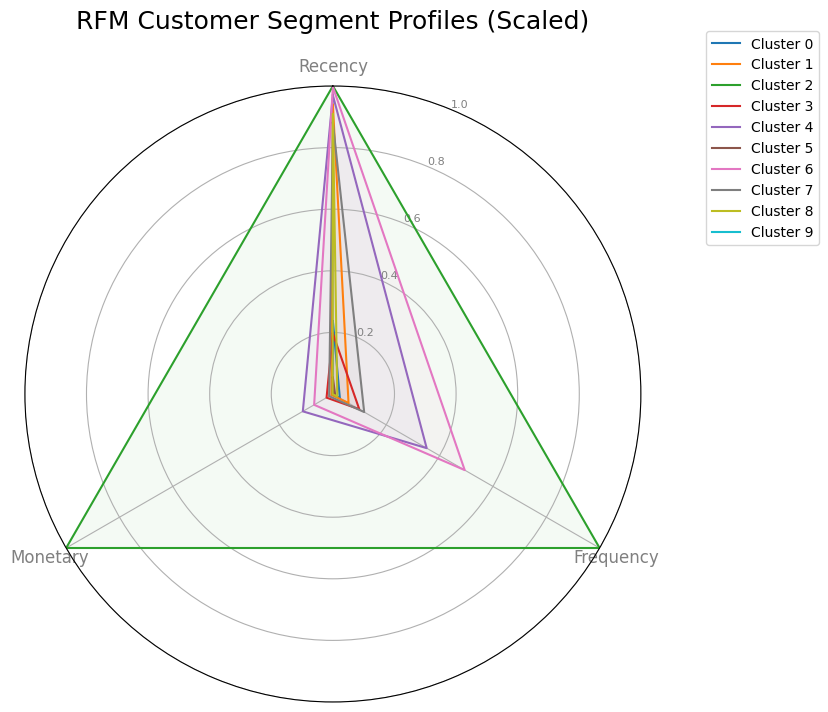

Radar chart generated successfully.


In [16]:
# Cell 14: Radar Chart Execution
print("\n--- Generating Radar Chart ---")
create_radar_chart(
    cluster_means_scaled_df_for_radar,
    'RFM Customer Segment Profiles (Scaled)',
    radar_features
)
print("Radar chart generated successfully.")

In [17]:
print(rfm)

             Recency  Frequency  Monetary  Cluster
Customer ID                                       
12346            326         12  77556.46        3
12347              2          8   5633.32        1
12348             75          5   2019.40        0
12349             19          4   4428.69        1
12350            310          1    334.40        9
...              ...        ...       ...      ...
18283              4         22   2736.65        7
18284            432          1    461.68        9
18285            661          1    427.00        9
18286            477          2   1296.43        0
18287             43          7   4182.99        1

[5878 rows x 4 columns]


In [18]:
# Cell 16: Cluster Evaluation Metrics

print("\n--- Evaluating Cluster Quality using Internal Metrics ---")

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Ensure X_scaled (from Cell 6) and cluster_labels (from Cell 10) are available.

if X_scaled.shape[0] > 1 and len(np.unique(cluster_labels)) > 1:
    try:
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        print(f"Silhouette Score: {silhouette_avg:.4f}")
        
        db_index = davies_bouldin_score(X_scaled, cluster_labels)
        print(f"Davies-Bouldin Index: {db_index:.4f}")
        
        ch_index = calinski_harabasz_score(X_scaled, cluster_labels)
        print(f"Calinski-Harabasz Index: {ch_index:.4f}")

        print("\nInterpretation of Scores:")
        print("- Silhouette Score: Closer to 1 is better, closer to -1 is worse.")
        print("- Davies-Bouldin Index: Lower is better, 0 is perfect separation.")
        print("- Calinski-Harabasz Index: Higher is better.")

    except Exception as e:
        print(f"Error calculating metrics: {e}")
        print("This might happen if there's only one cluster, or if data points are identical.")
else:
    print("Cannot calculate cluster evaluation metrics: Not enough samples or only one cluster found.")

print("Cluster evaluation metrics calculation complete.")


--- Evaluating Cluster Quality using Internal Metrics ---
Silhouette Score: 0.0089
Davies-Bouldin Index: 3.9816
Calinski-Harabasz Index: 977.1228

Interpretation of Scores:
- Silhouette Score: Closer to 1 is better, closer to -1 is worse.
- Davies-Bouldin Index: Lower is better, 0 is perfect separation.
- Calinski-Harabasz Index: Higher is better.
Cluster evaluation metrics calculation complete.
